In [ ]:
import os
import numpy as np
import librosa
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
from google.colab import drive

In [ ]:
# 스펙트로그램 생성 함수 (리사이즈 적용)
def extract_spectrogram_segment(y, sr, start, duration=10, n_mels=128):
    """
    오디오 신호에서 시작 시간부터 일정 기간의 스펙트로그램을 생성하고 리사이즈.
    """
    y_segment = y[int(start * sr):int((start + duration) * sr)]  # 특정 구간의 샘플 추출
    if len(y_segment) < duration * sr:  # 10초보다 짧은 구간 제외
        return None  # 작은 구간은 None 반환

    # 스펙트로그램 생성
    spectrogram = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_mels=n_mels)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # 스펙트로그램을 128x128 크기로 리사이즈 (OpenCV 활용)
    spectrogram_resized = cv2.resize(spectrogram_db, (128, 128), interpolation=cv2.INTER_CUBIC)
    return spectrogram_resized

# 데이터 로드 함수 (파일 단위로 나누기)
def load_data_by_files(data_path, labels, segment_duration=10):
    """
    오디오 파일별로 스펙트로그램 데이터를 생성하고 라벨을 매핑.
    """
    data_by_files = defaultdict(list)
    for label in labels:
        genre_folder = os.path.join(data_path, label)
        for file in os.listdir(genre_folder):
            if file.endswith('.wav'):  # .wav 파일만 처리
                file_path = os.path.join(genre_folder, file)
                try:
                    y, sr = librosa.load(file_path, sr=22050)  # 오디오 파일 로드 (샘플링 레이트: 22050)
                    total_duration = librosa.get_duration(y=y, sr=sr)
                    # 10초 단위로 데이터를 나눠 스펙트로그램 생성
                    for start in range(0, int(total_duration), segment_duration):
                        spectrogram = extract_spectrogram_segment(y, sr, start, duration=segment_duration)
                        if spectrogram is not None:  # 유효한 스펙트로그램만 추가
                            data_by_files[file].append((spectrogram, label))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return data_by_files

In [ ]:
# 데이터 로드
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/DataSet/genres_original'
CLASS_LABELS = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

print("Extracting features from audio files...")
data_by_files = load_data_by_files(DATA_PATH, CLASS_LABELS, segment_duration=10)

# 파일 이름 기반으로 데이터 분리
file_names = list(data_by_files.keys())
train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)

# 훈련 및 테스트 데이터 구성
X_train, y_train = [], []
X_test, y_test = [], []

for file in train_files:
    for spectrogram, label in data_by_files[file]:
        X_train.append(spectrogram)
        y_train.append(label)

for file in test_files:
    for spectrogram, label in data_by_files[file]:
        X_test.append(spectrogram)
        y_test.append(label)

# NumPy 배열로 변환
X_train = np.array(X_train)[..., np.newaxis]  # CNN 입력을 위한 채널 차원 추가 (128, 128, 1)
X_train = np.repeat(X_train, 3, axis=-1)  # VGG16은 3채널 이미지를 필요로 하므로 채널 복제 (128, 128, 3)
X_test = np.array(X_test)[..., np.newaxis]
X_test = np.repeat(X_test, 3, axis=-1)

# 라벨 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_encoded = to_categorical(y_train_encoded, num_classes=len(CLASS_LABELS))
y_test_encoded = label_encoder.transform(y_test)
y_test_encoded = to_categorical(y_test_encoded, num_classes=len(CLASS_LABELS))

# 사전 학습된 VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  # 사전 학습된 가중치를 고정

# 분류 계층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GAP 계층 추가
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASS_LABELS), activation='softmax')(x)

# 새 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting features from audio files...


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 649s 9s/step - accuracy: 0.1788 - loss: 4.2707 - val_accuracy: 0.4197 - val_loss: 1.6659
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 651s 9s/step - accuracy: 0.4458 - loss: 1.6271 - val_accuracy: 0.5117 - val_loss: 1.4047
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 682s 9s/step - accuracy: 0.5113 - loss: 1.4202 - val_accuracy: 0.5585 - val_loss: 1.2915
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 622s 8s/step - accuracy: 0.5606 - loss: 1.2428 - val_accuracy: 0.5585 - val_loss: 1.2243
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 678s 8s/step - accuracy: 0.5803 - loss: 1.1525 - val_accuracy: 0.5669 - val_loss: 1.1827
19/19 - 133s - 7s/step - accuracy: 0.5669 - loss: 1.1827
Test Accuracy: 56.69%


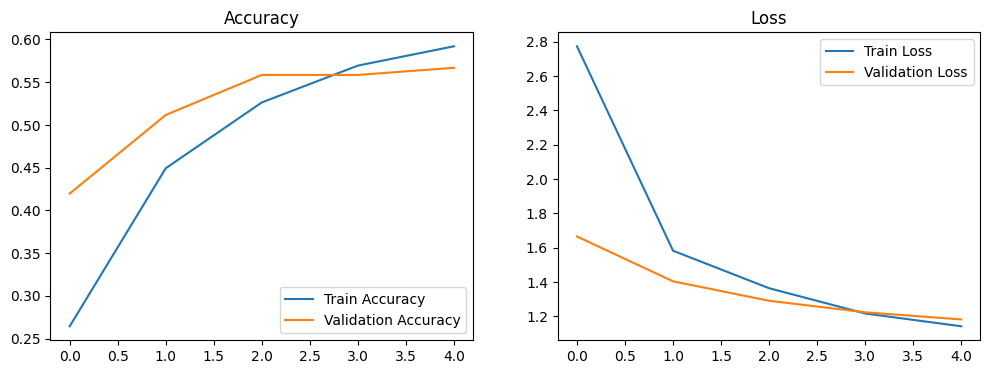

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_data=(X_test, y_test_encoded))

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 학습 과정 시각화
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)

In [ ]:
# 간단한 CNN 모델 정의
model = Sequential([
    # Conv Block 1
    Input(shape=(128, 128, 3)),  # 입력 크기 지정
    Conv2D(32, (3, 3), activation='relu', padding='same'),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),

    # Conv Block 4
    Conv2D(128, (3, 3), activation='relu', padding='same'),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASS_LABELS), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])